### makemore: lect03


### day14

- 202403120630--202403120800
- 202403122000--202403122100

### day 15
- 202403130845--202403131200
  
### day 16
- 202403140630--202403140800

### day 17
- 202403152100--202403152130


### day 18
- 202403161300--202403161500

  
### day 19
- 202403170900--202403171215
- 

In [162]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Any

### Constants

In [403]:
RANDOM_SEED = 10
NUM_BLOCKS = 3
NUM_DIM_CHARS = 2
NUM_HIDDEN = 20

### Random Generator

In [404]:
import random
import numpy as np

rand_gen = torch.Generator().manual_seed(RANDOM_SEED)
RAND_GEN = rand_gen

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Read File

In [405]:
words = open("names.txt").read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

### Make Mappings: `chr -> int` and `int -> chr`

In [406]:
ord("a"), ord("z"), ord("z") - ord("a") + 1, chr(ord("a")), chr(ord("z"))

(97, 122, 26, 'a', 'z')

In [407]:
itos = {i - ord("a") + 1: chr(i) for i in range(ord("a"), ord("z") + 1)}
itos[0] = "."

stoi = {s: i for i, s in itos.items()}

# stoi
# itos

In [408]:
chars = sorted(list(set("".join(words))))
chars[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [409]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

### Get Data

In [410]:
def get_data(words: List[str], num_blocks: int = 3, stoi=stoi) -> (List[torch.tensor], List[torch.tensor]):
    """get data"""

    X, Y = [], []


    # ## tese lines are for testing:
    # for word in words[:5]:
    #     print("-" * 80)

    for word in words:
        context = [0] * num_blocks
        for ch in word + ".":
            i = stoi[ch]
            # append the current char ch, i.e. the index i into Y;
            # at the same time append the current context into X;
            # (the context up to now) contains letters that preeced the char ch
            # print(" ".join((itos[ix] for ix in context)), "--->", ch)
            X.append(context)
            Y.append(i)
            context = context[1: ] + [i]
           

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [411]:
get_data(words)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [412]:
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)

In [413]:
X[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])

In [414]:
Y[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

### Split Data: `train`, `val/dev`, and `test`

In [415]:
X.shape, X.shape[0]

(torch.Size([228146, 3]), 228146)

In [416]:
Y.shape, Y.shape[0]

(torch.Size([228146]), 228146)

In [417]:
indexes = torch.randperm(X.shape[0], generator=rand_gen)
indexes[:10]

tensor([117017,  81926, 152774,   8097, 220660,  38770, 226753, 147220, 224337,
        175417])

In [418]:
# this list changes over time?!
torch.randperm(X.shape[0], generator=rand_gen)[:10]

tensor([184694,  31158,  21725,  15842,   3894,  75184,  50599, 156241, 116075,
         47106])

In [419]:
def split_data(X, y, split=0.8):
    
    """split data into train, val, and test sets"""
    
    assert X.shape[0] == y.shape[0], "input data X and Y sizes do not match."
    assert (0 < split and split < 1), "the split for training data should be within (0, 1)."
    
    len_data = X.shape[0]
    shuffled_indices = torch.randperm(X.shape[0], generator=rand_gen)

    len_train = int(split * len_data)
    len_val = (len_data - len_train) // 2
    len_test = len_data - len_train - len_val
    
    
    X_train = X[shuffled_indices][:len_train]
    X_val = X[shuffled_indices][len_train: len_train + len_val]
    X_test = X[shuffled_indices][- len_test:]
    
    y_train = Y[shuffled_indices][:len_train]
    y_val = Y[shuffled_indices][len_train: len_train + len_val]
    y_test = Y[shuffled_indices][- len_test:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [420]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

In [421]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

### MLP revisted

### Develop Model

- `C` is a mapping that translates `chars` into a `dim`-dimensional vector space;

In [422]:
### given the context X; 
### we predict the following char given in Y; 
### and the prediction belongs in one out of 27 classes; 
### i.e. there are 27 chars as a possibility for it. 

vocab_size = 27 

In [423]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * num_blocks, n_hidden), generator=g) * (5 /3) / ((n_embed * num_blocks) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


### Pay attention about shapes

In [424]:
hpreact.shape

torch.Size([182516, 200])

In [425]:
torch.randn((5, ), generator=rand_gen)

tensor([-0.4777,  0.5704,  0.1981,  0.3437,  0.7030])

In [426]:
torch.randn(5, generator=rand_gen)

tensor([-1.0422, -0.6502, -0.3110,  1.1155, -0.2288])

In [427]:
torch.randn((5, 1), generator=rand_gen)

tensor([[-1.1359],
        [ 0.2450],
        [-0.9370],
        [ 0.2569],
        [ 0.0738]])

### Optimization

In [428]:
X_train.shape[0]

182516

In [429]:
# mini-batch construct
batch_size = 32
ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
# print(i, ix)
X_batch, Y_batch = X_train[ix], Y_train[ix]
X_batch.shape, C.shape

(torch.Size([32, 3]), torch.Size([27, 10]))

In [430]:
# C: 27 x 10 
# X_batch: 32 x 3 

emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [431]:
emb.view(emb.shape[0], -1).shape

torch.Size([32, 30])

In [432]:
X_batch

tensor([[ 8,  5, 14],
        [ 0, 26, 21],
        [ 0,  0, 11],
        [12,  1, 25],
        [ 0,  1, 13],
        [ 3,  9,  1],
        [ 9, 15, 12],
        [ 0,  0,  0],
        [19, 19,  1],
        [10,  5,  4],
        [ 8,  5, 12],
        [18,  1, 14],
        [15, 14,  4],
        [14, 14,  1],
        [12,  5, 24],
        [ 5, 11,  5],
        [ 0, 18,  5],
        [20,  8, 15],
        [ 0,  0, 20],
        [ 1, 18,  9],
        [15, 18,  5],
        [12,  5,  5],
        [ 0,  0,  0],
        [25, 12,  1],
        [ 9, 13,  5],
        [13, 13, 25],
        [19,  1,  3],
        [ 1, 22,  9],
        [11,  1, 13],
        [19,  4, 18],
        [13, 21, 14],
        [ 0,  0,  4]])

In [433]:
C.shape

torch.Size([27, 10])

In [434]:
C[0].shape

torch.Size([10])

In [435]:
C[X_batch[2]].shape

torch.Size([3, 10])

In [436]:
X_batch[2]

tensor([ 0,  0, 11])

In [437]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [438]:
C[19]

tensor([-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
        -0.4528, -0.4958], grad_fn=<SelectBackward0>)

In [439]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830], grad_fn=<SelectBackward0>)

In [440]:
C[[0, 19, 5]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
         -0.4528, -0.4958],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [441]:
C[X_batch[2]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.5653,  0.5428,  0.1755, -2.2901, -0.7093, -0.2928, -2.1803,  0.0793,
          0.9019,  1.2028]], grad_fn=<IndexBackward0>)

In [442]:
emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [443]:
emb_cat = emb.view(emb.shape[0], -1)
emb_cat.shape

torch.Size([32, 30])

In [444]:
W1.shape

torch.Size([30, 200])

In [445]:
h = emb_cat @ W1 + b1
h.shape

torch.Size([32, 200])

In [446]:
W2.shape

torch.Size([200, 27])

In [447]:
(h @ W2).shape

torch.Size([32, 27])

In [448]:
b2.shape

torch.Size([27])

In [449]:
Y_batch.shape

torch.Size([32])

In [450]:
X.shape

torch.Size([228146, 3])

In [451]:
X_batch.shape, emb.shape, emb_cat.shape, W1.shape, hpreact.shape, W2.shape, logits.shape

(torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([32, 30]),
 torch.Size([30, 200]),
 torch.Size([182516, 200]),
 torch.Size([200, 27]),
 torch.Size([4]))

In [452]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [453]:
hpreact.mean(0, keepdim=True)[0][0], hpreact[:,0].sum()/32

(tensor(-0.9989), tensor(-5697.1841))

In [454]:
hpreact.mean(1, keepdim=True).shape

torch.Size([182516, 1])

In [455]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [456]:
hpreact.mean(0, keepdim=True)

tensor([[-9.9887e-01, -1.8329e-01, -1.1433e+00,  5.6621e-01,  9.7805e-01,
          6.4823e-01,  1.5945e+00, -7.9978e-01, -3.1081e-01,  5.9067e-01,
         -8.3885e-01, -1.2084e+00, -6.8020e-02, -3.0545e-02, -1.6788e-01,
          2.7226e-01,  3.9010e-01, -1.6930e+00, -4.3225e-01,  7.0700e-01,
          4.8594e-01, -8.6084e-01,  2.1570e-02,  8.8921e-01,  3.5603e-01,
          3.4840e-01,  7.6621e-01,  2.5047e-01, -2.5232e-01,  1.0309e+00,
         -7.7984e-02, -9.0223e-01,  2.7511e-01,  3.4681e-01, -7.1472e-01,
         -5.7751e-01, -5.5666e-01, -9.2207e-01, -3.4140e-01,  4.8140e-01,
          1.8645e-01, -1.1088e+00, -9.1647e-01, -2.9286e-01,  3.8051e-01,
          4.7191e-01,  1.3767e-01, -6.9014e-01,  8.2005e-01,  1.3721e+00,
          6.1427e-02,  2.9183e-01,  1.5726e+00,  1.3158e+00,  9.3567e-01,
         -1.0939e+00,  5.5737e-02,  6.5574e-01,  1.1979e+00, -6.6507e-01,
         -1.8612e-01, -2.5319e-01,  7.3957e-01,  3.1094e-01,  8.8855e-01,
          7.4198e-01,  1.0127e+00,  4.

In [457]:
hpreact.std(0, keepdim=True)

tensor([[1.9995, 1.2675, 1.5950, 1.6113, 1.8897, 1.6295, 1.1355, 1.3359, 1.7991,
         1.4293, 1.4820, 1.6339, 1.6347, 1.8880, 1.1168, 1.5588, 2.3405, 1.3529,
         1.6875, 1.5661, 1.5978, 1.8278, 1.7543, 2.1450, 1.5181, 1.4544, 1.3805,
         1.7051, 2.2965, 1.9299, 1.2911, 1.5209, 2.3757, 1.4275, 2.3276, 1.4533,
         1.3971, 2.1254, 1.7170, 1.8066, 1.4096, 1.8005, 1.7134, 2.4926, 1.3841,
         2.0919, 1.7980, 1.9985, 1.1684, 1.8402, 1.4068, 1.3264, 1.2931, 1.8524,
         1.8313, 1.7460, 1.3743, 2.0908, 2.3346, 1.4236, 1.5077, 1.5714, 1.2346,
         1.6053, 1.8385, 1.7161, 1.6900, 1.4562, 1.6463, 1.9368, 1.7630, 1.9361,
         1.5478, 1.1225, 1.5237, 1.7943, 1.8790, 2.1204, 1.8952, 1.7660, 2.4125,
         1.6388, 1.7713, 2.0973, 1.7737, 1.6914, 1.6149, 1.6390, 1.7942, 1.4224,
         1.6519, 1.6552, 1.8678, 2.7755, 2.4232, 1.5751, 2.1565, 1.9939, 1.1930,
         1.9975, 1.5969, 1.7625, 2.4413, 1.2349, 1.6391, 1.4210, 1.8485, 1.5322,
         1.6732, 1.9670, 1.7

In [459]:
max_steps = 5_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass: 
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    # break


    200 /    5000; 2.3757
    400 /    5000; 2.1496
    600 /    5000; 2.7424
    800 /    5000; 1.9865
   1000 /    5000; 2.4246
   1200 /    5000; 2.4148
   1400 /    5000; 2.3028
   1600 /    5000; 2.2446
   1800 /    5000; 2.3273
   2000 /    5000; 2.3911
   2200 /    5000; 2.3945
   2400 /    5000; 2.6197
   2600 /    5000; 2.2767
   2800 /    5000; 2.0008
   3000 /    5000; 2.1800
   3200 /    5000; 2.4440
   3400 /    5000; 2.3578
   3600 /    5000; 2.3341
   3800 /    5000; 2.4496
   4000 /    5000; 1.9611
   4200 /    5000; 2.5516
   4400 /    5000; 2.3729
   4600 /    5000; 2.4792
   4800 /    5000; 2.4506
   5000 /    5000; 2.7129


In [460]:
lossi[:10]

[2.333235025405884,
 2.313763380050659,
 2.39801287651062,
 2.634168863296509,
 2.125823974609375,
 2.204030752182007,
 2.1245312690734863,
 2.421417713165283,
 2.6089954376220703,
 2.3375353813171387]

In [461]:
h, h.shape

(tensor([[ 0.6665, -0.9553, -0.4320,  ..., -0.9238, -0.5630, -0.4603],
         [ 0.6611, -0.9314,  0.1337,  ..., -0.0710, -0.6726, -0.8771],
         [-0.7518,  0.3584,  0.5607,  ..., -0.3646,  0.8167,  0.5329],
         ...,
         [-0.7518,  0.3584,  0.5607,  ..., -0.3646,  0.8167,  0.5329],
         [-0.5121,  0.1154,  0.2454,  ...,  0.4095,  0.6562,  0.0010],
         [ 0.6665, -0.9553, -0.4320,  ..., -0.9238, -0.5630, -0.4603]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

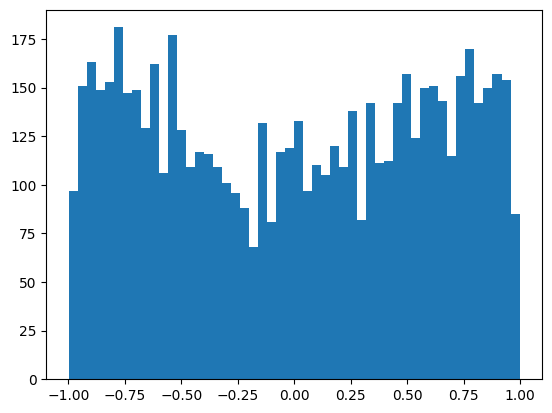

In [462]:
plt.hist(h.view(-1).tolist(), 50);

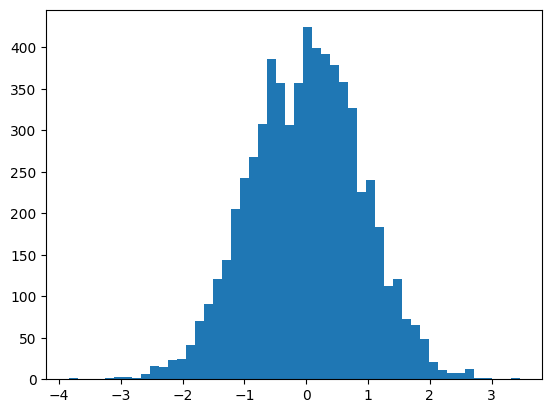

In [463]:
plt.hist(hpreact.view(-1).tolist(), 50);

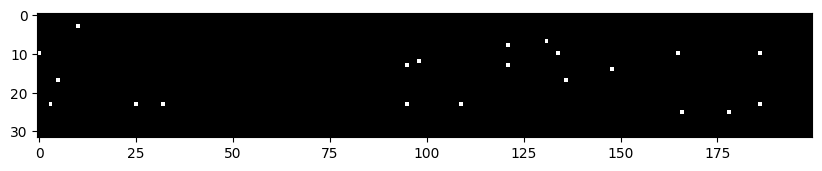

In [464]:
plt.figure(figsize=(10, 20))
plt.imshow(h.abs() >= 0.99, cmap="gray", interpolation="nearest")

### White = 1, True; and Black = 0 False;

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(0 * h.abs() >= 0.99, cmap="gray", interpolation="nearest")

In [ ]:
h.shape, hpreact.shape

In [ ]:
lossi[:10]

In [ ]:
plt.plot(lossi)
plt.grid(True)

In [ ]:
logits[0]

In [ ]:
probs = torch.softmax(logits[0], dim=0)
probs.sum()
# plt.imshow()

In [ ]:
probs = torch.softmax(logits, dim=1)

In [ ]:
probs.shape

In [ ]:
probs[0].shape, probs[0].sum(), probs[1].shape, probs[1].sum()

In [ ]:
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [ ]:
bnmean

In [ ]:
bnmean_running

In [ ]:
bnstd

In [ ]:
bnstd_running

In [ ]:
@torch.no_grad()
def evaluate(split: str):

    data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }
   
    x, y = data_map[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{split = }, {loss.item() = }")

In [ ]:
evaluate("train")    
evaluate("val")    
evaluate("test")    

In [195]:
# sample from the model 
rg = torch.Generator().manual_seed(RANDOM_SEED + 10)

for t in range(20):
    out = []
    context = [0] * NUM_BLOCKS
    while True:
        # emb = C[torch.tensor([context])]
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs_test = F.softmax(logits)
        probs = F.softmax(logits, dim=1)
    
        ix = torch.multinomial(probs, num_samples=1, generator=rg)
        ch = itos[ix.item()]
        # print(ch)  
        context = context[1:] + [ix]
        out.append(ix)
    
        if ix == 0:
            break
    print(t, "".join(itos[i.item()] for i in out))
    
    # print("".join()

0 kgwyd.
1 muckh.
2 puxjazgrdxizk.
3 brcjifjand.
4 chivuh.
5 embnth.
6 vyzgltc.
7 javghbgrigg.
8 ffpfpttrvfxskxvzdinokbqobrixs.
9 chpkmvwahn.
10 bzmbacxiddopkyvskemmstqfivghnlengbbblxwisthvopklrnnxxnzhlyngerlynn.
11 mardlynn.
12 jlixxjjxxdirkkesz.
13 ngulllmaczfxnngergxtomembryxghvdre.
14 zyzclymqliggbrghigblorrandabcamtellegubrx.
15 flsthradwovgengb.
16 krkkjkyng.
17 nbvr.
18 dovkenghamwyxsmigbhslymonghbwllynn.
19 frjixg.


/tmp/ipykernel_23055/1897569945.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_test = F.softmax(logits)


In [264]:
emb = C[torch.tensor(context)]

In [265]:
emb.shape

torch.Size([3, 10])

In [266]:
emb.view(1, -1).shape

torch.Size([1, 30])

In [267]:
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [268]:
probs_t.shape

NameError: name 'probs_t' is not defined

In [269]:
probs.shape

torch.Size([4])

In [270]:
probs_t.sum()

NameError: name 'probs_t' is not defined

In [203]:
logits.shape

torch.Size([1, 27])

In [204]:
logits = torch.tensor([100.0, 0.0, 0.0, 0.0])
logits = torch.rand(4) * 100
probs = torch.softmax(logits, dim=0)

In [205]:
probs

tensor([1.5287e-07, 1.8203e-06, 7.2707e-14, 1.0000e+00])

In [206]:
loss = - probs[2].log()

In [207]:
logits, probs, loss

(tensor([45.8085, 48.2857, 31.2498, 61.5022]),
 tensor([1.5287e-07, 1.8203e-06, 7.2707e-14, 1.0000e+00]),
 tensor(30.2523))

In [208]:
torch.randn(10).shape

torch.Size([10])

In [209]:
for i in range(10):
    r = torch.randn(100)
    print(# r.mean().item(), 
          r.std().item())

0.8959280252456665
1.0698953866958618
0.9664099812507629
1.1011399030685425
0.8539541959762573
0.9838457107543945
1.0581798553466797
0.8983544111251831
1.0232785940170288
1.009940505027771


### day 17

In [210]:
class Linear:
        
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if (bias is not None) else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=10**(-5), momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = Trueself.dim = dim
        

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training: 
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # print("-" * 80)
        # print(f"{xhat.shape = }")
        # print(f"{self.gamma.shape = }")
        # print(f"{self.beta.shape = }")
        
        
        self.out = self.gamma * xhat + self.beta
        
        with torch.no_grad():
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
    
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [211]:
vocab_size, n_embed, num_blocks

(27, 10, 3)

In [212]:
C = torch.randn((vocab_size, n_embed), generator=g)

# this is without batch normalization
layers = [
    Linear(num_blocks * n_embed, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# this is with batch normalization
layers = [
    Linear(num_blocks * n_embed, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]


In [213]:
# layers[-1].weight *= 0.1
layers[-1].gamma *= 0.1
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.75 # 5/3 # 1 # 3

In [214]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [215]:
sum(p.nelement() for p in parameters)

174751

### optimization

In [216]:
max_steps = 500
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # forward pass
    x = emb_cat
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Y_batch) # loss function


    # backward pass: 
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    with torch.no_grad():
        ud.append(
            [(lr * p.grad).std() / p.data.std().log10().item() for p in parameters]
            # lr * p.grad / p.data
        )
        
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    break


In [217]:
loss

tensor(3.2791, grad_fn=<NllLossBackward0>)

In [218]:
x.shape

torch.Size([32, 27])

In [219]:
print(f"{len(layers) = }")
[type(layer) for layer in layers]

len(layers) = 17


[__main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d,
 __main__.Tanh,
 __main__.Linear,
 __main__.BatchNorm1d]

### Visualize Tanh Outs

layer 2; name: Tanh; mean 0.0040; std: 0.6187; saturated: 14.05%
layer 5; name: Tanh; mean -0.0022; std: 0.6247; saturated: 13.56%
layer 8; name: Tanh; mean 0.0025; std: 0.6228; saturated: 13.41%
layer 11; name: Tanh; mean 0.0021; std: 0.6308; saturated: 13.39%
layer 14; name: Tanh; mean -0.0005; std: 0.6328; saturated: 12.77%


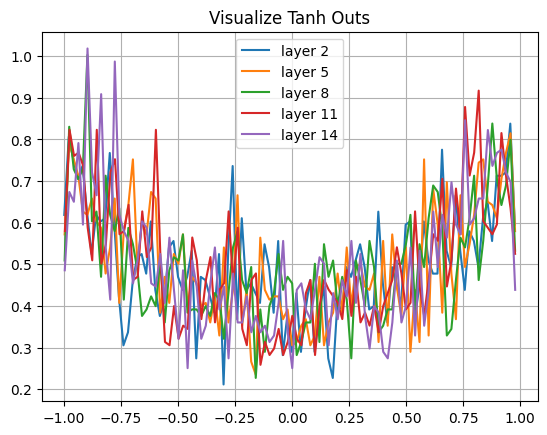

In [220]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Outs")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()


### Visualize Tanh Grads

layer 2; name: Tanh; mean -0.0000; std: 0.0008; saturated: 0.00%
layer 5; name: Tanh; mean 0.0000; std: 0.0006; saturated: 0.00%
layer 8; name: Tanh; mean 0.0000; std: 0.0005; saturated: 0.00%
layer 11; name: Tanh; mean -0.0000; std: 0.0004; saturated: 0.00%
layer 14; name: Tanh; mean 0.0000; std: 0.0004; saturated: 0.00%


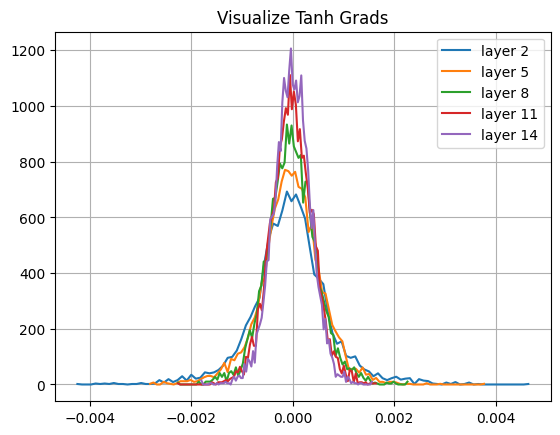

In [221]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out.grad
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Grads")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()

In [222]:
t.detach()

tensor([[-2.0547e-04, -4.0680e-04, -6.7861e-05,  ...,  1.1718e-04,
         -7.0379e-04, -5.4079e-04],
        [ 5.4703e-05,  3.7219e-04, -4.5058e-05,  ..., -6.5472e-05,
         -3.9061e-04, -2.7716e-04],
        [-4.6945e-04,  4.5559e-04, -2.6972e-04,  ..., -3.1105e-04,
         -4.0902e-04, -8.9738e-05],
        ...,
        [ 1.3399e-04,  2.1683e-04,  5.4422e-06,  ..., -9.2973e-05,
          4.3609e-04,  1.2280e-05],
        [ 3.7871e-04,  1.0744e-04, -4.9032e-04,  ..., -6.6989e-05,
          4.4023e-04, -5.8900e-04],
        [-2.4130e-04,  1.7326e-04,  1.7649e-04,  ...,  4.6239e-04,
         -4.6211e-04, -2.3370e-05]])

In [223]:
(t.abs() > 0.9)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [224]:
(t.abs() > 0.9).float().mean()

tensor(0.)

In [225]:
layer.__class__?

Init signature: layer.__class__(dim, eps=1e-05, momentum=0.1)
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [226]:
layer.__class__.__dict__

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.BatchNorm1d.__init__(self, dim, eps=1e-05, momentum=0.1)>,
              '__call__': <function __main__.BatchNorm1d.__call__(self, x)>,
              'parameters': <function __main__.BatchNorm1d.parameters(self)>,
              '__dict__': <attribute '__dict__' of 'BatchNorm1d' objects>,
              '__weakref__': <attribute '__weakref__' of 'BatchNorm1d' objects>,
              '__doc__': None})

In [227]:
layer.__class__.__name__

'BatchNorm1d'

### Visualize Parameters: Grad to Data Ratio

In [228]:
# plt.close()

for cnt, p in enumerate(parameters):
    if p.dim() == 2:
        t = p.grad.mean() / p.data.mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; shape: {p.shape}; mean {p.mean():0.4f}; std: {p.std():0.4f}; grad:data ratio: {p.grad.mean() / p.data.mean():0.2f}%")
        # hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        # plt.title("Visualize Tanh Grads")
        # plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break

# plt.grid(True)
# plt.legend()


layer 0; name: BatchNorm1d; shape: torch.Size([27, 10]); mean 0.0524; std: 1.0048; grad:data ratio: 0.00%
layer 1; name: BatchNorm1d; shape: torch.Size([30, 200]); mean 0.0006; std: 0.1353; grad:data ratio: 0.01%
layer 5; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0000; std: 0.0530; grad:data ratio: -0.59%
layer 9; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0002; std: 0.0525; grad:data ratio: -0.03%
layer 13; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0003; std: 0.0529; grad:data ratio: -0.06%
layer 17; name: BatchNorm1d; shape: torch.Size([200, 200]); mean -0.0002; std: 0.0532; grad:data ratio: 0.06%
layer 21; name: BatchNorm1d; shape: torch.Size([200, 27]); mean -0.0009; std: 0.0527; grad:data ratio: 0.02%


In [229]:
len(parameters)

25

### This is does not work!

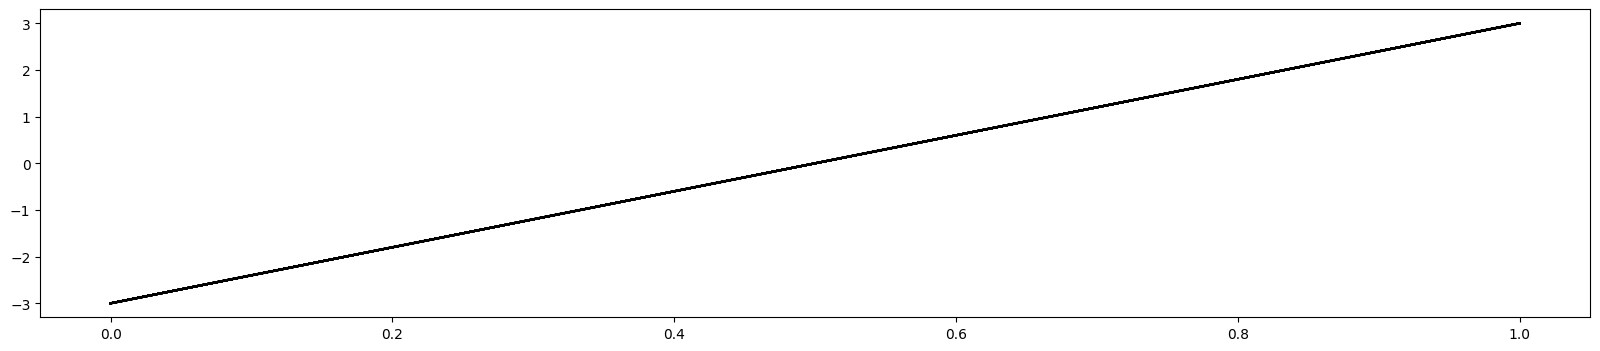

In [230]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.dim == 2:
        # plt.plot([ud[j][i] for j in range(len(ud))])
        plt.plot(ud[i])
        
    plt.plot([0, len(ud)], [-3, 3], "k")
plt.show()

### 202404009072500--??

In [985]:
DEBUG = False
# -------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5) ## kaiming init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if (self.bias is not None):
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if (self.bias is None) else [self.bias])

# -------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=10**(-5), momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if DEBUG:
            zz = torch.sqrt(xvar) #  + self.eps)
            
            print(f"{x.shape = }")
            print(f"{xmean.shape = }")
            print(f"{xvar.shape = }")
            print(f"{xhat.shape = }")
            print(f"{self.gamma.shape = }")
            print(f"{self.beta.shape = }")
            print(f"{self.out.shape = }")
            print(f"{zz.shape = }")
            
            print(f"{self.eps = }")
            print(f"{x = }")
            print(f"{xmean = }")
            print(f"{xvar = }")
            print(f"{xhat = }")
            print(f"{zz = }")
            print(f"{self.gamma = }")
            print(f"{self.beta = }")
            print(f"{self.out = }")

        # update buffers: 
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.beta, self.gamma]


# -------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

# -------------------------------------------------
class Embedding:
    # def __init__(self, vocab_size, n_embed):
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, indexes):
        self.out = self.weight[indexes]
        return self.out
        
    def parameters(self):
        return [self.weight]

# -------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
        
    def parameters(self):
        return []

In [986]:
torch.manual_seed(42)

### define a network as a list of layers:

In [1031]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

In [1032]:
C = torch.randn((vocab_size, n_embed))

In [1033]:
C.shape

torch.Size([27, 10])

In [1034]:
layers = [
    Linear(fan_in=num_blocks * n_embed, fan_out=n_hidden, bias=True),
    BatchNorm1d(dim=n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
]

In [1035]:
layers

In [1036]:
# make the last layer less confident
with torch.no_grad():
    layers[-1].weights *= 0.1

In [1037]:
# parameters = [C] + [p for p in layer for layer in layers]
# parameters = [C] + [p for p in layer.paparameters() for layer in layers]

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [1038]:
len(parameters)

7

In [1039]:
[p.nelement() for p in parameters]

[270, 6000, 200, 200, 200, 5400, 27]

In [1040]:
sum((p.nelement() for p in parameters))

12297

In [1041]:
layers

In [1042]:
C.nelement

<function Tensor.nelement>

In [1043]:
layers[0]

In [1044]:
layers[0].weights.nelement(), layers[0].bias.nelement()

(6000, 200)

In [1045]:
layers[1]

In [1046]:
layers[1].parameters()

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.,

In [1047]:
layers[1].gamma.nelement(), layers[1].beta.nelement()

(200, 200)

In [1048]:
layers[2]

In [1049]:
layers[2].parameters()

[]

In [1050]:
layers[3]

In [1051]:
layers[3].weights

tensor([[ 1.9428e-03,  5.3470e-03,  2.0561e-03,  ..., -2.6522e-03,
          2.2360e-03,  8.2572e-03],
        [-9.9708e-04, -8.9251e-03,  2.5492e-03,  ...,  1.7090e-02,
          4.6501e-04,  6.2390e-03],
        [-2.7863e-03,  2.7669e-03,  1.7423e-05,  ..., -7.6401e-03,
          2.4171e-03,  2.4271e-03],
        ...,
        [-1.5214e-03,  1.0407e-02,  1.1743e-03,  ...,  4.4015e-04,
          1.8131e-03,  3.1662e-03],
        [-2.5737e-03, -4.8453e-03, -3.1470e-03,  ...,  2.0892e-03,
          1.0792e-02, -8.2824e-03],
        [ 2.9045e-03,  1.3676e-02,  3.6171e-03,  ..., -5.1124e-03,
          7.6875e-03,  1.5304e-04]], requires_grad=True)

In [1052]:
layers[3].weights.nelement(), layers[3].bias.nelement()

(5400, 27)

### Training: 

In [1053]:
X_train.size(), Y_train.size()

(torch.Size([182516, 3]), torch.Size([182516]))

In [1054]:
len_data = X_train.shape[0]
print(len_data)

182516


In [1055]:
max_steps = 50_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[X_batch]
    emb_cat = emb.view(emb.shape[0], -1)
    if DEBUG:
        print(f"{emb.shape = }")
        print(f"{emb = }")
        print(f"{emb_cat.shape = }")
        
    x = emb_cat
    for layer in layers:
        x = layer(x)
        if DEBUG:
            print("-" * 80)
            print(f"{layer = }")
            print(f"{x.shape = }")
            print(f"{x = }")
            
    loss = F.cross_entropy(x, Yb)

    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()


    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())

   1000 /   50000; 2.7113
   2000 /   50000; 2.8561
   3000 /   50000; 2.7813
   4000 /   50000; 2.9944
   5000 /   50000; 2.9598
   6000 /   50000; 3.0237
   7000 /   50000; 2.9710
   8000 /   50000; 3.1226
   9000 /   50000; 2.9118
  10000 /   50000; 2.6899
  11000 /   50000; 2.7143
  12000 /   50000; 2.9072
  13000 /   50000; 2.9015
  14000 /   50000; 2.9918
  15000 /   50000; 2.9888
  16000 /   50000; 3.1369
  17000 /   50000; 2.8417
  18000 /   50000; 2.6591
  19000 /   50000; 2.8168
  20000 /   50000; 3.0284
  21000 /   50000; 2.8136
  22000 /   50000; 2.5774
  23000 /   50000; 2.9686
  24000 /   50000; 2.6246
  25000 /   50000; 2.7010
  26000 /   50000; 2.8369
  27000 /   50000; 2.8120
  28000 /   50000; 3.0784
  29000 /   50000; 2.5928
  30000 /   50000; 2.5357
  31000 /   50000; 2.9119
  32000 /   50000; 2.5104
  33000 /   50000; 2.7384
  34000 /   50000; 2.8025
  35000 /   50000; 2.8671
  36000 /   50000; 2.5667
  37000 /   50000; 2.8274
  38000 /   50000; 3.0531
  39000 /   

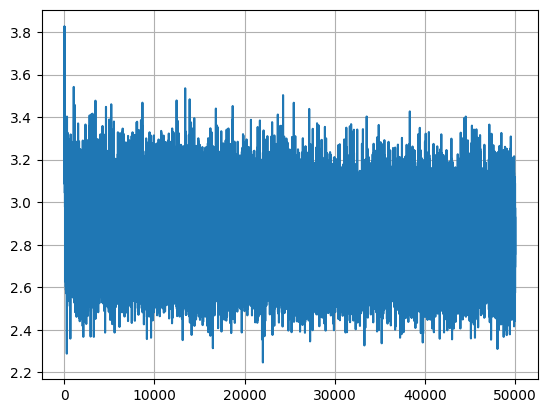

In [1056]:
plt.plot(lossi)
plt.grid(True)

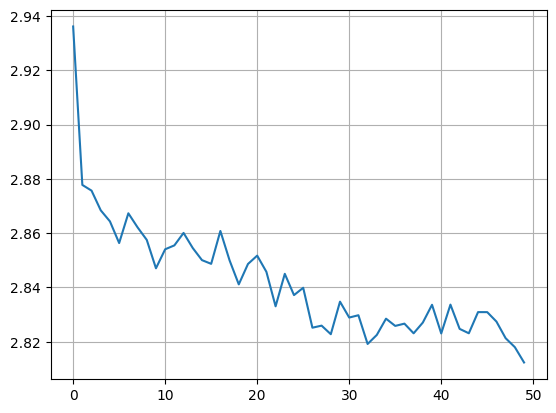

In [1057]:
plt.plot(
    torch.FloatTensor(lossi).view(-1, 1000).mean(dim=1)
)
plt.grid(True)

### A new way after adding layers `Embedding` and `Flatten`

In [1058]:
layers = [
    Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
    Flatten(),
    Linear(fan_in=num_blocks * n_embed, fan_out=n_hidden, bias=True),
    BatchNorm1d(dim=n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, bias=True),    
]

In [1059]:
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 50_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(len_data)[:batch_size]
    # print(f"{ix = }")
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)    
    loss = F.cross_entropy(x, Yb)
 
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()


    # update rule: 
    lr = 0.1 if (i < max_steps * 0.5) else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # stats
    if (i + 1) % (max_steps // 50) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
        
    # store loss
    lossi.append(loss.detach().item())

In [ ]:
plt.plot(lossi)
plt.grid(True)

In [ ]:
plt.plot(
    torch.FloatTensor(lossi).view(-1, 1000).mean(dim=1)
)
plt.grid(True)